In [1]:
import asyncio
from tardis_client import TardisClient, Channel
import pandas as pd
import numpy as np
import grpc
import sys
import inference_pb2_grpc as pb2_grpc
import inference_pb2 as pb2
import matplotlib.pyplot as plt
import math
import statistics

In [2]:
class TestClient(object):
    """
    Client for testing inference gRPC
    """

    def __init__(self):
        self.host = '3.139.238.241'
        #self.host = 'localhost'
        self.server_port = 5125

        # instantiate a channel
        self.channel = grpc.insecure_channel(
            '{}:{}'.format(self.host, self.server_port))

        # bind the client and the server
        self.stub = pb2_grpc.InferenceStub(self.channel)

    def send(self, tx, modelHash, modelInput):
        """
        Client function to call the rpc for inference
        """
        message = pb2.InferenceParameters(tx=tx, modelHash=modelHash, modelInput = modelInput)
        return self.stub.RunInference(message)

def inference(vol5b, vol10b, vol20b):
    client = TestClient()
    result = client.send(tx = "0x123", modelHash="QmXQpupTphRTeXJMEz3BCt9YUF6kikcqExxPdcVoL1BBhy", modelInput=str([[vol5b, vol10b, vol20b]]))
    return float(result.value)

In [3]:
async def kraken(symbol, start_date, end_date):
    data = []
    tardis_client = TardisClient(api_key='REDACTED')

    messages = tardis_client.replay(
        exchange="kraken",
        from_date=start_date,
        to_date=end_date,
        filters=[Channel(name="spread", symbols=[symbol])],
    )
    
    async for local_timestamp, message in messages:
        timestamp = float(message[1][2])
        bid = float(message[1][0])
        ask = float(message[1][1])
        mid = (bid + ask) / 2
        spread = abs(ask-bid) / mid
        data.append([timestamp, mid, spread])
    return data

data = sorted(await kraken("ETH/USDT", "2022-11-09", "2022-11-12"), key=lambda x: x[0])

In [4]:
raw_df = pd.DataFrame(data, columns =['timestamp', 'price', 'spread'], dtype = float).sort_values(by=['timestamp'])    

In [5]:
i = 1
price_sum = data[0][1]
spread_sum = data[0][2]
count = 1
timestamp = data[0][0]
processed_data = []
while i < len(data):
    if (data[i][0] - timestamp > 12):
        processed_data.append([timestamp, price_sum/count, spread_sum/count])
        timestamp = data[i][0]
        price_sum = data[i][1]
        spread_sum = data[i][2]
        count = 1
    else:
        count += 1
        price_sum += data[i][1]
        spread_sum += data[i][2]
    i += 1

In [6]:
df = pd.DataFrame(processed_data, columns =['timestamp', 'price', 'spread'], dtype = float).sort_values(by=['timestamp'])    

In [7]:
windows = [5, 10, 20]
for w in windows:
    df['vol_' + str(w) + 'b'] = df['price'].rolling(w).std() / df['price']
    df['spread_' + str(w) + 'b'] = df['spread'].rolling(w).mean()
df = df.dropna()

In [8]:
df.head()

,timestamp,price,spread,vol_5b,spread_5b,vol_10b,spread_10b,vol_20b,spread_20b
19,1.667952e+09,1325.861937,0.000586,0.000504,0.000489,0.001121,0.000401,0.002846,0.000343
20,1.667952e+09,1325.477406,0.000650,0.000454,0.000553,0.001114,0.000446,0.002846,0.000361
21,1.667952e+09,1325.287278,0.000649,0.000392,0.000597,0.001052,0.000479,0.002853,0.000380
22,1.667952e+09,1324.852297,0.000458,0.000357,0.000569,0.000742,0.000497,0.002784,0.000385
23,1.667952e+09,1324.969898,0.000495,0.000306,0.000568,0.000465,0.000506,0.002548,0.000391


In [9]:
class eth_usdc:
    def __init__(self, eth, usdc):
        self.profit = 0
        self.eth = eth
        self.usdc = usdc
        self.product = eth * usdc
    
    def trade(self, direction, eth, price, fee):
        self.profit += fee * (eth * price)
        eth = eth * (1-fee)
        if direction == 'buy':
            return self.buy(eth, price)
        else:
            return self.sell(eth, price)
    
    # Returns amount of ETH in USD terms
    def buy(self, eth, price):
        self.eth -= eth
        diff = (self.product / self.eth) - self.usdc 
        self.usdc = self.product / self.eth
        return diff * price
    
    # Returns amount of USDC received
    def sell(self, eth, price):
        self.eth += eth
        diff = (self.eth - (self.product / self.usdc)) * price
        self.usdc = self.product / self.eth
        return diff

    def balance(self, price):
        return self.profit + self.usdc + (price * self.eth)
    
    def buy_profitable(self, eth, usdc, price, fee):
        return (math.sqrt((usdc*eth*(1-fee))) - usdc) / (1-fee)
    
    def sell_profitable(self, eth, usdc, price, fee):
        return (math.sqrt((usdc*eth*(1-fee))/price) - eth) / (1-fee)
    

In [10]:
history1 = {"fee": [], "eth": [], "usdc": [], "price": [], "balance": [], "lvr": []}
lvr = 0
pool = eth_usdc(1000000, 1000000 * df.iloc[0,1])
for date, row in df.T.iteritems():
    fee = inference(row['vol_5b'], row['vol_10b'], row['vol_20b'])
    history1['fee'].append(fee)
    #fee = history['fee'][len(history1['eth'])]
    history1['eth'].append(pool.eth)
    history1['usdc'].append(pool.usdc)
    history1['price'].append(row['price'])
    history1['balance'].append(pool.balance(row['price']))
    buy_amt = pool.buy_profitable(pool.eth, pool.usdc, row['price'], fee) != 0
    sell_amt = pool.sell_profitable(pool.eth, pool.usdc, row['price'], fee) != 0
    if (buy_amt > 0):
        lvr += pool.trade('buy', buy_amt, row['price'], fee)
    elif (sell_amt > 0):
        lvr += pool.trade('sell', sell_amt, row['price'], fee)
    history1['lvr'].append(lvr / pool.balance(row['price']))

<ipython-input-10-a8488d8afa67>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, row in df.T.iteritems():


In [11]:
history2 = {"fee": [], "eth": [], "usdc": [], "price": [], "balance": [], "lvr": []}
lvr = 0
pool = eth_usdc(1000000, 1000000 * df.iloc[0,1])
for date, row in df.T.iteritems():
    fee = statistics.median(history1['fee'])
    history2['fee'].append(fee)
    history2['eth'].append(pool.eth)
    history2['usdc'].append(pool.usdc)
    history2['price'].append(row['price'])
    history2['balance'].append(pool.balance(row['price']))
    buy_amt = pool.buy_profitable(pool.eth, pool.usdc, row['price'], fee) != 0
    sell_amt = pool.sell_profitable(pool.eth, pool.usdc, row['price'], fee) != 0
    if (buy_amt > 0):
        lvr += pool.trade('buy', buy_amt, row['price'], fee)
    elif (sell_amt > 0):
        lvr += pool.trade('sell', sell_amt, row['price'], fee)
    history2['lvr'].append(lvr / pool.balance(row['price']))

<ipython-input-11-b337cfb74e3d>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for date, row in df.T.iteritems():


In [41]:
results = pd.DataFrame(list(zip(history1['balance'], history2['balance'], history1['lvr'], history2['lvr'])),columns =['Dynamic_Balance', 'Static_Balance','Dynamic_LVR', 'Static_LVR'])
results['Delta_Balance'] = (results['Dynamic_Balance'] - results['Static_Balance']) / ((results['Dynamic_Balance'] + results['Static_Balance'])/2)
results['Delta_LVR'] = results['Dynamic_LVR'] - results['Static_LVR']

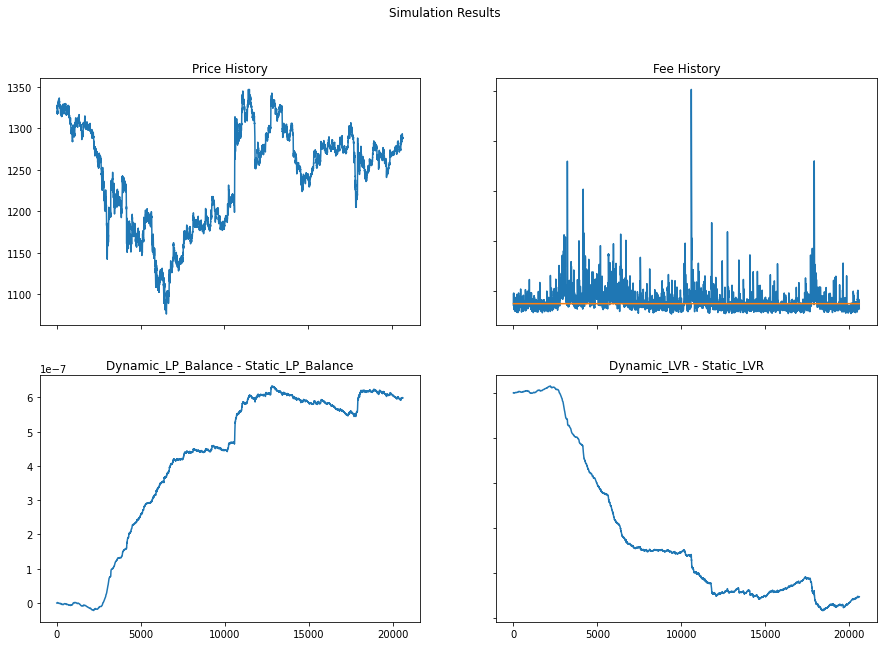

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Simulation Results')
ax1.plot(df['price'])
ax1.set_title("Price History")
ax2.plot(history1['fee'])
ax2.set_title("Fee History")
ax2.plot(history2['fee'])
ax3.plot(results['Delta_Balance'])
ax3.set_title("Dynamic_LP_Balance - Static_LP_Balance")
ax4.plot(results['Delta_LVR'])
ax4.set_title("Dynamic_LVR - Static_LVR")

for ax in fig.get_axes():
    ax.label_outer()

No handles with labels found to put in legend.


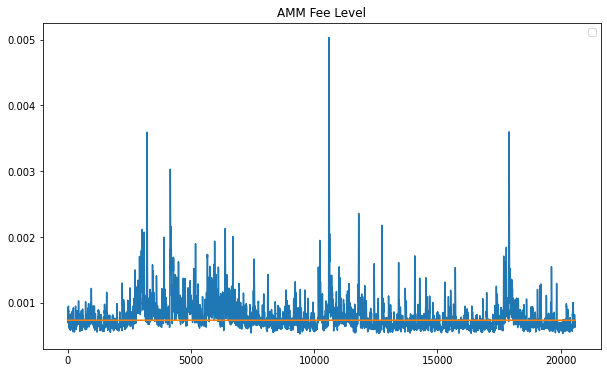

In [36]:
plt.figure(figsize=(10,6))
plt.plot(history1['fee'])
plt.plot(history2['fee'])
plt.title("AMM Fee Level")
plt.legend()

Text(0.5, 1.0, 'Dynamic_LP_Balance - Static_LP_Balance (in %)')

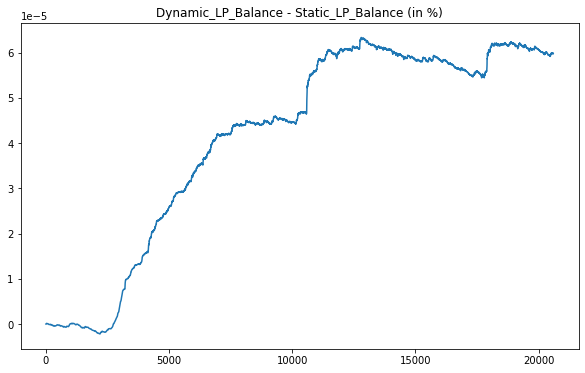

In [45]:
plt.figure(figsize=(10,6))
plt.plot(results['Delta_Balance']*100)
plt.title("Dynamic_LP_Balance - Static_LP_Balance (in %)")

In [46]:
# On chain simulation